In [1]:
# import statements including namaster python wrapper
import numpy as np
import healpy as hp
import os
import pymaster as nmt
import pysm3
import pysm3.units as u
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import warnings
warnings.filterwarnings("ignore")

In [2]:
# matplotlib formatting
rc('text', usetex=True)
res_dpi = 300
ext = 'pdf'

# Masking

We downloaded a mask from the Planck Legacy Archive that leaves 70% of the sky uncovered, lowered its resolution to
match those of our maps at an Nside of 128, and apodized it on a scale of about three degrees. Later in our analysis, we remove most noise from our Galaxy by applying this galactic plane mask to all calculations, maps, and skies.

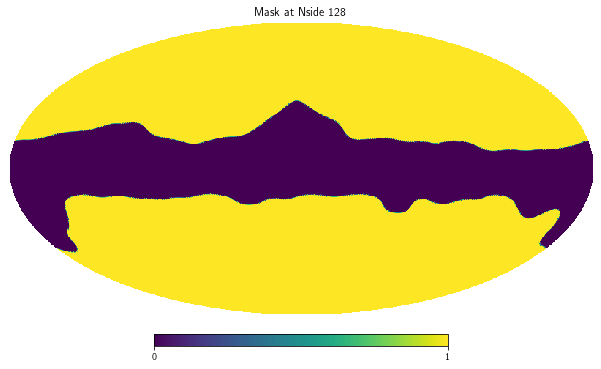

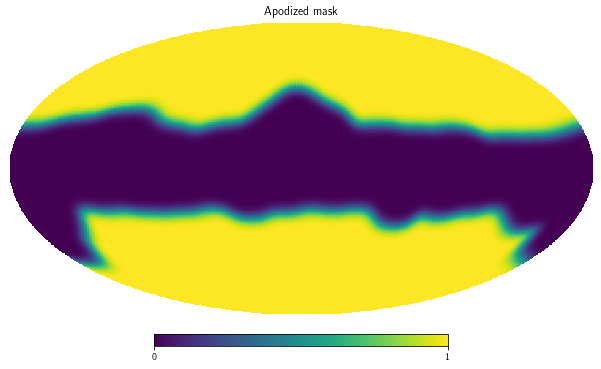

In [3]:
# read in a planck mask, lower resolution, and apodize it on a scale of ~3 degrees
# HEALPix resolution parameter
nside = 128
# initialize binning scheme with 12 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 12)
# read planck mask (GAL070) and lower resolution to nside=128
mask = hp.read_map("HFI_Mask_GalPlane-apo0_2048_R2.00.fits", field=3)
mask_128 = hp.pixelfunc.ud_grade(mask, 128, dtype=float)
hp.mollview(mask_128, title='Mask at Nside 128')
# save mask
hp.write_map("mask_GAL070_128.fits", mask_128, dtype=float, overwrite=True)
# read mask and apodize it on a scale of ~3degs
mask = nmt.mask_apodization(hp.read_map("mask_GAL070_128.fits", verbose=False), 3., apotype="Smooth")
hp.mollview(mask, title='Apodized mask')

# Decorrelation of PySM Models at Higher Frequencies

We use PySM to generate a sky and a 217 GHz map according to the d0 model. We then use pymaster, a python wrapper for the NaMaster software package, to compute the Cℓ(217 × 217) value and initialize the spin-2 fields required to calculate RℓBB and RℓEE, and the spin-0 field needed to compute RℓTT.

With the skies, maps, and spin fields corresponding to the d0 model and the first term under the square root of the spectral correlation ratio available, we use pymaster to calculate the cross power spectra for various frequencies against the 217 GHz map as well as the second term under the square root in order to complete the calculation of the ratio. In other words, we perform the spectral correlation ratio for values of ν from 300 GHz to 3000 GHz.

Once the correlation statistic is calculated using an ℓ of 80 for each of the specified frequencies, the process is repeated for all PySM models.

In [4]:
# functions that take in a map, the map_217, the cl1x1 value, and the map 217 field and outputs r80 value for BB, EE, or TT
def rbb80(map_nu2, clbb1x1, f2_map_nu1, mask):
    # initialize spin-2 field for map2
    f2_map_nu2 = nmt.NmtField(mask, map_nu2, purify_b = True)
    clbb1x2 = nmt.compute_full_master(f2_map_nu1, f2_map_nu2, b)[3][6]
    clbb2x2 = nmt.compute_full_master(f2_map_nu2, f2_map_nu2, b)[3][6]
    return clbb1x2/(np.sqrt(clbb1x1*clbb2x2))
def ree80(map_nu2, clee1x1, f2_map_nu1, mask):
    # initialize spin-2 field for map2
    f2_map_nu2 = nmt.NmtField(mask, map_nu2, purify_e = True)
    clee1x2 = nmt.compute_full_master(f2_map_nu1, f2_map_nu2, b)[0][6]
    clee2x2 = nmt.compute_full_master(f2_map_nu2, f2_map_nu2, b)[0][6]
    return clee1x2/(np.sqrt(clee1x1*clee2x2))
def rtt80(map_nu2, cltt1x1, f0_map_nu1, mask):
    # initialize spin-0 field for map2
    f0_map_nu2 = nmt.NmtField(mask, [map_nu2])
    cltt1x2 = nmt.compute_full_master(f0_map_nu1, f0_map_nu2, b)[0][6]
    cltt2x2 = nmt.compute_full_master(f0_map_nu2, f0_map_nu2, b)[0][6]
    return cltt1x2/(np.sqrt(cltt1x1*cltt2x2)) 

In [5]:
freqs = np.arange(150,3000,150)
rbb80_vals = np.ones((len(freqs),13))*1.
ree80_vals = np.ones((len(freqs),13))*1.
rtt80_vals = np.ones((len(freqs),13))*1.
# HEALPix resolution parameter
nside = 128
# initialize binning scheme with 10 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 12)

# for all of the pysm models
for i in range(13):
    # make a sky
    sky = pysm3.Sky(nside=128, preset_strings=["d"+str(i)])
    # make 217GHz map
    map_217GHz = sky.get_emission(217 * u.GHz)
    # initialize a spin-2 field for BB & EE and a spin-0 field for TT, compute their cl80 values
    f2_map_nu1_bb = nmt.NmtField(mask, map_217GHz[1:,:], purify_b = True)
    clbb1x1 = nmt.compute_full_master(f2_map_nu1_bb, f2_map_nu1_bb, b)[3][6]
    f2_map_nu1_ee = nmt.NmtField(mask, map_217GHz[1:,:], purify_e = True)
    clee1x1 = nmt.compute_full_master(f2_map_nu1_ee, f2_map_nu1_ee, b)[0][6]
    f0_map_nu1 = nmt.NmtField(mask, [map_217GHz[0]])
    cltt1x1 = nmt.compute_full_master(f0_map_nu1, f0_map_nu1, b)[0][6]
    # compute Rl[80] for every 150GHz from 150GHz to 3THz
    for j, freq in enumerate(freqs):
        map_freq = sky.get_emission(freq * u.GHz)
        rbb80_vals[j][i] = (1 - rbb80(map_freq[1:,:], clbb1x1, f2_map_nu1_bb, mask))
        ree80_vals[j][i] = (1 - ree80(map_freq[1:,:], clee1x1, f2_map_nu1_ee, mask))
        rtt80_vals[j][i] = (1 - rtt80(map_freq[0,:], cltt1x1, f0_map_nu1, mask))
np.savetxt("rbb80_vals217.txt", rbb80_vals)
np.savetxt("ree80_vals217.txt", ree80_vals)
np.savetxt("rtt80_vals217.txt", rtt80_vals)

No physical unit associated with file /home/mnorton/.astropy/cache/download/url/437b2626b1f29ce20de57ce934c44436/contents


Plotted on the x-axis of Figure 1 are the frequencies of each map correlated with the 217 GHz map. Because we observe small differences in correlation, we subtract the correlation statistic from one and plot that value on the y-axis. Since a correlation ratio of zero means there is no correlation between the two frequencies, no correlation among all the frequencies would appear on this figure as a horizontal line equal to one. Conversely, a horizontal line at zero would denote perfect correlation among all frequencies. It should be noted that perfect correlation would not appear on this figure since both axes are plotted logarithmically. This is what happens with both the d0 and d8 models because they have
perfect correlation due set temperature and β parameters.

The authors of the Planck paper did an analysis of their data to calculate the actual spectral correlation ratio between data at their two highest frequencies, 217 GHz and 353 GHz, and found a correlation limit of 99.1% This implies that, at 353 GHz, any viable model in PySM would have at least this level of correlation.

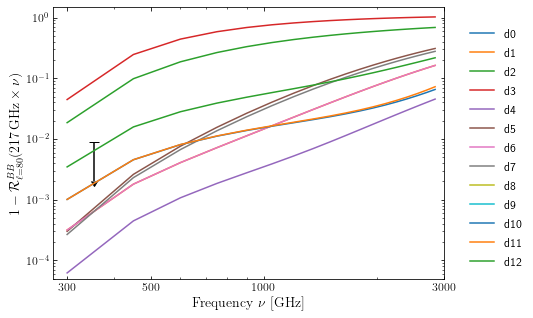

In [6]:
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{BB}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)

for i in range(13):
    ax.plot(freqs[1:], rbb80_vals[1:,i], label= 'd'+str(i))
ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('all_models_217_bb.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

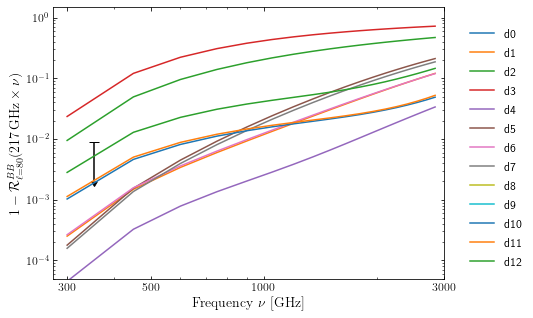

In [7]:
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{BB}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)

for i in range(13):
    ax.plot(freqs[1:], ree80_vals[1:,i], label= 'd'+str(i))
ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('all_models_217_ee.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

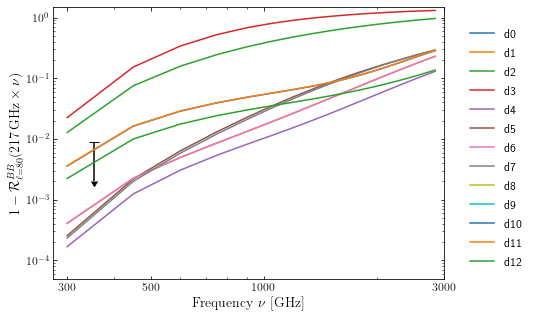

In [8]:
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{BB}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)

for i in range(13):
    ax.plot(freqs[1:], rtt80_vals[1:,i], label= 'd'+str(i))
ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('all_models_217_tt.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

# Determining the Maximum Range for β in the d2 and d3 Models

In order to find the largest range for β that satisfies the Planck restriction, we alter the d2 model to have a standard deviation of 0.01 then perform the same correlation statistic from the previous analysis and plot the results. We increase the standard deviation by 0.01 until it reaches a value of 0.2, which is the original β value for the d2 model that we know to be
too large. To alter the standard deviation of the d2 model, we replace the assigned “map mbb index” with a new map with the specified standard deviation β. To create a new map in a way that is similar to how the original d2 map was created, we create an array of random numbers with length 3145728 (corresponding to an Nside of 512), smooth the map to one degree resolution, and manipulate the random values to have a mean of 1.59 and the desired standard deviation.

In [9]:
beta_vals = np.arange(0.01,0.2,0.01)
rbb80_vals_std = np.ones((len(freqs),20))*1.

for i, beta in enumerate(beta_vals):
    rand512=np.random.randn(3145728)
    d2p2_fwhm = hp.sphtfunc.smoothing(rand512,fwhm=0.01745)
    d2p2 = d2p2_fwhm*(beta/np.std(d2p2_fwhm))+1.59
    hp.fitsfunc.write_map("beta_mean1p59_std0p0"+str(i+1)+".fits",d2p2, dtype=float, overwrite=True)
    
os.environ["PYSM_LOCAL_DATA"] = os.getcwd()

# for all of the beta values
for i, beta in enumerate(beta_vals):
    dust = pysm3.ModifiedBlackBody(
        nside = 128,
        map_I = "pysm_2/dust_t_new.fits",
        map_Q = "pysm_2/dust_q_new.fits",
        map_U = "pysm_2/dust_u_new.fits",
        unit_I = "uK_RJ",
        unit_Q = "uK_RJ",
        unit_U = "uK_RJ",
        map_mbb_index = "beta_mean1p59_std0p0"+str(i+1)+".fits",
        map_mbb_temperature = "pysm_2/dust_temp.fits",
        unit_mbb_temperature = "K",
        freq_ref_I = "545 GHz",
        freq_ref_P = "353 GHz"
    )
    # make 217GHz map
    map_217GHz = dust.get_emission(217 * u.GHz)
    # initialize a spin-2 field for BB & EE and a spin-0 field for TT, compute their cl80 values
    f2_map_nu1_bb = nmt.NmtField(mask, map_217GHz[1:,:], purify_b = True)
    clbb1x1 = nmt.compute_full_master(f2_map_nu1_bb, f2_map_nu1_bb, b)[3][6]
    
    # compute Rl[80] for every 150GHz from 150GHz to 3THz
    for j, freq in enumerate(freqs):
        map_freq = dust.get_emission(freq * u.GHz)
        rbb80_vals_std[j][i] = (1 - rbb80(map_freq[1:,:], clbb1x1, f2_map_nu1_bb, mask))

np.savetxt("rbb80_vals217_std.txt", rbb80_vals_std)

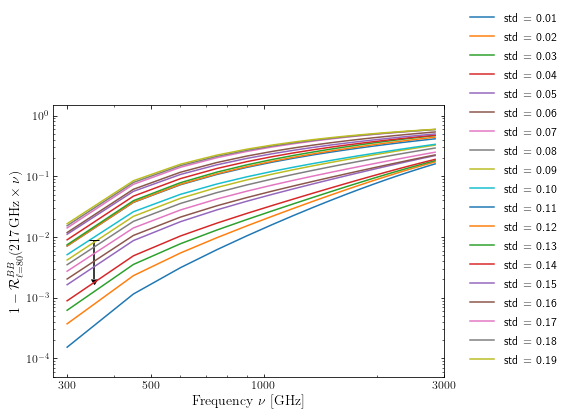

In [10]:
# matplotlib formatting
rc('text', usetex=True)
res_dpi = 300
ext = 'pdf'

fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{BB}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)

rbb80_vals_2 = np.loadtxt('rbb80_vals217_d2p2.txt', usecols=range(20))
for i, beta in enumerate(beta_vals):
    if i<9:
        ax.plot(freqs[1:], rbb80_vals_2[1:,i], label= 'std = 0.0'+str(i+1))
    else:
        ax.plot(freqs[1:], rbb80_vals_2[1:,i], label= 'std = 0.'+str(i+1))

ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('max_std.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

# Relative Dependence of the d1 Model on β and Temperature

The modified blackbody used to simulate thermal dust only depends on two parameters - temperature and β. To differentiate the influence each parameter has on the d1 model, we compute the correlation statistic for all frequencies using three models: 1) the regular d1 model given by PySM, 2) the d1 model with a fixed temperature of 20K, and 3) the d1 model with a fixed β value of 1.54. To simulate the latter two models, we simply create a map of fixed temperature and a map of fixed β and use the component class within PySM to alter the original d1 presets.

In [11]:
# make map of constant temp (20K)
temp_20 = np.ones(3145728)*20
hp.fitsfunc.write_map("temp_20.fits",temp_20, dtype=float, overwrite=True)
# mape map of constant beta (1.54)
beta_1p54 = np.ones(3145728)*1.54
hp.fitsfunc.write_map("beta_1p54.fits",beta_1p54, dtype=float, overwrite=True)

rbb80_vals_temp = np.ones(len(freqs))*1.
rbb80_vals_beta = np.ones(len(freqs))*1.
rbb80_vals_d1 = np.ones(len(freqs))*1.
ree80_vals_temp = np.ones(len(freqs))*1.
ree80_vals_beta = np.ones(len(freqs))*1.
ree80_vals_d1 = np.ones(len(freqs))*1.
rtt80_vals_temp = np.ones(len(freqs))*1.
rtt80_vals_beta = np.ones(len(freqs))*1.
rtt80_vals_d1 = np.ones(len(freqs))*1.

temp = pysm3.ModifiedBlackBody(
    nside = 128,
    map_I = "pysm_2/dust_t_new.fits",
    map_Q = "pysm_2/dust_q_new.fits",
    map_U = "pysm_2/dust_u_new.fits",
    unit_I = "uK_RJ",
    unit_Q = "uK_RJ",
    unit_U = "uK_RJ",
    map_mbb_index = "pysm_2/dust_beta.fits",
    map_mbb_temperature = "temp_20.fits",
    unit_mbb_temperature = "K",
    freq_ref_I = "545 GHz",
    freq_ref_P = "353 GHz"
)

beta = pysm3.ModifiedBlackBody(
    nside = 128,
    map_I = "pysm_2/dust_t_new.fits",
    map_Q = "pysm_2/dust_q_new.fits",
    map_U = "pysm_2/dust_u_new.fits",
    unit_I = "uK_RJ",
    unit_Q = "uK_RJ",
    unit_U = "uK_RJ",
    map_mbb_index = "beta_1p54.fits",
    map_mbb_temperature = "pysm_2/dust_temp.fits",
    unit_mbb_temperature = "K",
    freq_ref_I = "545 GHz",
    freq_ref_P = "353 GHz"
)

# make a sky
sky = pysm3.Sky(nside=128, preset_strings=["d1"])
# make 217GHz map
map_217GHz = sky.get_emission(217 * u.GHz)
map_217GHz_temp = temp.get_emission(217 * u.GHz)
map_217GHz_beta = beta.get_emission(217 * u.GHz)
# initialize a spin-2 field for BB & EE and a spin-0 field for TT
f2_bb_d1 = nmt.NmtField(mask, map_217GHz[1:,:], purify_b = True)
f2_bb_temp = nmt.NmtField(mask, map_217GHz_temp[1:,:], purify_b = True)
f2_bb_beta = nmt.NmtField(mask, map_217GHz_beta[1:,:], purify_b = True)
f2_ee_d1 = nmt.NmtField(mask, map_217GHz[1:,:], purify_e = True)
f2_ee_temp = nmt.NmtField(mask, map_217GHz_temp[1:,:], purify_e = True)
f2_ee_beta = nmt.NmtField(mask, map_217GHz_beta[1:,:], purify_e = True)
f0_tt_d1 = nmt.NmtField(mask, [map_217GHz[0]])
f0_tt_temp = nmt.NmtField(mask, [map_217GHz_temp[0]])
f0_tt_beta = nmt.NmtField(mask, [map_217GHz_beta[0]])
# compute their cl80 values
clbb1x1_d1 = nmt.compute_full_master(f2_bb_d1, f2_bb_d1, b)[3][6]
clbb1x1_temp = nmt.compute_full_master(f2_bb_temp, f2_bb_temp, b)[3][6]
clbb1x1_beta = nmt.compute_full_master(f2_bb_beta, f2_bb_beta, b)[3][6]
clee1x1_d1 = nmt.compute_full_master(f2_ee_d1, f2_ee_d1, b)[0][6]
clee1x1_temp = nmt.compute_full_master(f2_ee_temp, f2_ee_temp, b)[0][6]
clee1x1_beta = nmt.compute_full_master(f2_ee_beta, f2_ee_beta, b)[0][6]
cltt1x1_d1 = nmt.compute_full_master(f0_tt_d1, f0_tt_d1, b)[0][6]
cltt1x1_temp = nmt.compute_full_master(f0_tt_temp, f0_tt_temp, b)[0][6]
cltt1x1_beta = nmt.compute_full_master(f0_tt_beta, f0_tt_beta, b)[0][6]
# compute Rl[80] for every 150GHz from 150GHz to 3THz
for i, freq in enumerate(freqs):
    map_freq_d1 = sky.get_emission(freq * u.GHz)
    map_freq_temp = temp.get_emission(freq * u.GHz)
    map_freq_beta = beta.get_emission(freq * u.GHz)
    rbb80_vals_d1[i] = (1 - rbb80(map_freq_d1[1:,:], clbb1x1_d1, f2_bb_d1, mask))
    rbb80_vals_temp[i] = (1 - rbb80(map_freq_temp[1:,:], clbb1x1_temp, f2_bb_temp, mask))
    rbb80_vals_beta[i] = (1 - rbb80(map_freq_beta[1:,:], clbb1x1_beta, f2_bb_beta, mask))
    ree80_vals_d1[i] = (1 - ree80(map_freq_d1[1:,:], clee1x1_d1, f2_ee_d1, mask))
    ree80_vals_temp[i] = (1 - ree80(map_freq_temp[1:,:], clee1x1_temp, f2_ee_temp, mask))
    ree80_vals_beta[i] = (1 - ree80(map_freq_beta[1:,:], clee1x1_beta, f2_ee_beta, mask))
    rtt80_vals_d1[i] = (1 - rtt80(map_freq_d1[0,:], cltt1x1_d1, f0_tt_d1, mask))
    rtt80_vals_temp[i] = (1 - rtt80(map_freq_temp[0,:], cltt1x1_temp, f0_tt_temp, mask))
    rtt80_vals_beta[i] = (1 - rtt80(map_freq_beta[0,:], cltt1x1_beta, f0_tt_beta, mask))

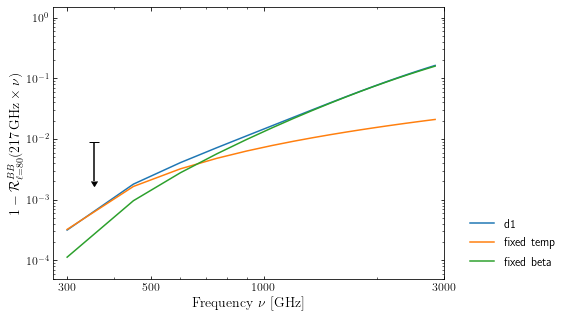

In [12]:
# plot all d1, temp, and beta for BB
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{BB}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)


ax.plot(freqs[1:], rbb80_vals_d1[1:], label= 'd1')
ax.plot(freqs[1:], rbb80_vals_temp[1:], label= 'fixed temp')
ax.plot(freqs[1:], rbb80_vals_beta[1:], label= 'fixed beta')

ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('bb_temp_beta.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

In [ ]:
# plot all d1, temp, and beta for EE
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{EE}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)


ax.plot(freqs[1:], ree80_vals_d1[1:], label= 'd1')
ax.plot(freqs[1:], ree80_vals_temp[1:], label= 'fixed temp')
ax.plot(freqs[1:], ree80_vals_beta[1:], label= 'fixed beta')

ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('ee_temp_beta.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')

In [ ]:
# plot all d1, temp, and beta for TT
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{TT}_{\ell=80} (217\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([275, 3000.,  0.00005, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.errorbar([353], [1-0.991], yerr=[.007], uplims = True, color = 'k', marker='_', markersize=10)


ax.plot(freqs[1:], rtt80_vals_d1[1:], label= 'd1')
ax.plot(freqs[1:], rtt80_vals_temp[1:], label= 'fixed temp')
ax.plot(freqs[1:], rtt80_vals_beta[1:], label= 'fixed beta')

ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('tt_temp_beta.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')